# Tutorial For RoM Calculation


## Introduction

This tutorial will show you how to calculate the RoM of a given state.


## A matrix

The A matrix is defined as the set of all pure stabilizer states in Pauli basis.

For example, the A matrix for 1 qubit is defined as follows:

![A matrix for 1 qubit](./doc/summary/imgs/Amat_1.png)


In [1]:
import numpy as np
from exputils.actual_Amat import get_actual_Amat

Amat1 = get_actual_Amat(1).toarray()
print(Amat1)

[[ 1  1  1  1  1  1]
 [ 1 -1  0  0  0  0]
 [ 0  0  1 -1  0  0]
 [ 0  0  0  0  1 -1]]


## b vector

We convert a given density matrix into a vector in Pauli basis, which is called b vector or $\rho$ vector.


In [2]:
import qutip
from exputils.state.state_in_pauli_basis import state_in_pauli_basis

I = np.array([[1, 0], [0, 1]])
X = np.array([[0, 1], [1, 0]])
Z = np.array([[1, 0], [0, -1]])
Y = np.array([[0, -1j], [1j, 0]])

n_qubit = 1
state = qutip.rand_dm_ginibre(2**n_qubit, seed=0).full()

print("density matrix:", state, sep="\n", end="\n\n")

rho_vec_def = np.array(
    [np.trace(state @ pauli_matrix) for pauli_matrix in [I, X, Y, Z]]
)

print("state in pauli basis (definition):", rho_vec_def, sep="\n", end="\n\n")

rho_vec = state_in_pauli_basis(state)
print("state in pauli basis (function):", rho_vec, sep="\n")

density matrix:
[[0.63280184-5.91216718e-18j 0.2389964 +3.24793793e-01j]
 [0.2389964 -3.24793793e-01j 0.36719816+5.91216718e-18j]]

state in pauli basis (definition):
[ 1.        +0.00000000e+00j  0.47799281+0.00000000e+00j
 -0.64958759+0.00000000e+00j  0.26560369-1.18243344e-17j]

state in pauli basis (function):
[ 1.          0.47799281 -0.64958759  0.26560369]


## RoM

The RoM is defined as the optimal solution of the following optimization problem:

$$
\begin{align*}
\text{minimize}_{\bm{x}} & ||\bm{x}||_1 \\
     \text{ subject to } & \bm{A} \bm{x}= \bm{b}
\end{align*}
$$

This is equivalent to the following LP problem:

$$
\begin{align*}
\text{minimize}_{\bm{u}} & \sum_{i} u_i \\
     \text{ subject to } & \begin{pmatrix} \bm{A}_{n} & -\bm{A}_{n} \end{pmatrix} \bm{u} = \bm{b} \\
                         & \bm{u} \geq 0
\end{align*}
$$


In [3]:
from scipy.optimize import linprog

A_and_minus_A = np.hstack([Amat1, -Amat1])

sz = Amat1.shape[1]  # = |S_n| = 2^n \prod_{i=1}^{n} (2^n+1) = 6

res = linprog(
    c=np.ones(2 * sz),
    A_eq=A_and_minus_A,
    b_eq=rho_vec,
    bounds=[0, None],
)

quasi_prob = res.x[:sz] - res.x[sz:]

print("optimal value (RoM):", res.fun)
print("quasi probabilities:", quasi_prob)

assert np.allclose(res.fun, np.linalg.norm(quasi_prob, ord=1))
assert np.allclose(Amat1 @ quasi_prob, rho_vec)

optimal value (RoM): 1.3931840770273858
quasi probabilities: [ 0.47799281  0.          0.          0.64958759  0.06901165 -0.19659204]


## Relationship to the inner product

The quasi-probability distribution has a relationship to the inner product of each stabilizer state and the given state.


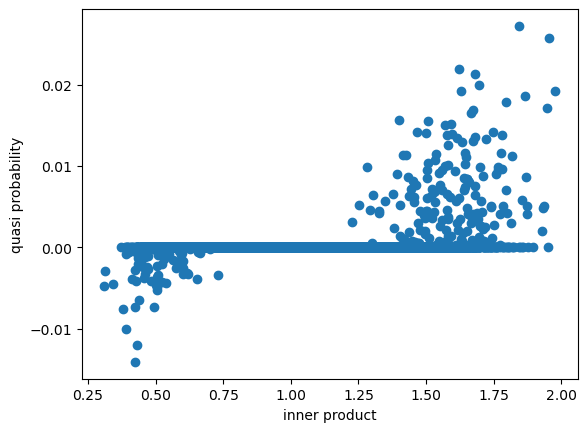

In [4]:
from exputils.RoM.custom import calculate_RoM_custom
from exputils.state.random import make_random_quantum_state
import matplotlib.pyplot as plt


Amat4 = get_actual_Amat(4)
rho_vec = make_random_quantum_state("mixed", n_qubit=4, seed=0)

inner_products = rho_vec @ Amat4

quasi_prob = calculate_RoM_custom(Amat4, rho_vec)[1]

plt.scatter(inner_products, quasi_prob)
plt.xlabel("inner product")
plt.ylabel("quasi probability")
plt.show()

## FWHT for the inner product

The inner product can be calculated by the fast Walsh-Hadamard transform (FWHT).

### FWHT

Firstly, we show the FWHT itself. The Walsh Hadamard matrix is defined as follows:

$$
\begin{align*}
    \bm{H}_1 &= \begin{pmatrix} 1 & 1 \\ 1 & -1 \end{pmatrix} \\
  \bm{H}_{n} &= \bm{H}_{n-1} \otimes \bm{H}_1 \; (n \geq 2)
\end{align*}
$$


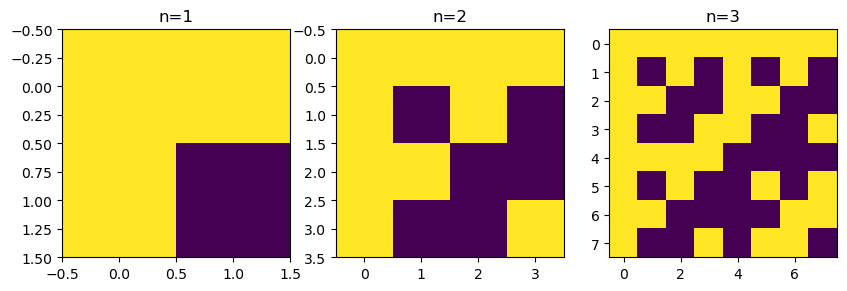

In [5]:
from exputils.math.fwht import sylvesters

fig = plt.figure(figsize=(10, 3))
for n in range(1, 3 + 1):
    ax = fig.add_subplot(1, 3, n)
    walsh = sylvesters(n)
    ax.imshow(walsh)
    ax.set_title(f"{n=}")

In [6]:
from exputils.math.fwht import FWHT

n = 2
walsh = sylvesters(n)
vec = np.array([1.0, 2.0, 3.0, 4.0])

print("                   normal matrix product", walsh @ vec)
print("product by Fast Walsh Hadamard Transform", FWHT(n, vec) * (2**n))

                   normal matrix product [10. -2. -4.  0.]
product by Fast Walsh Hadamard Transform [10. -2. -4.  0.]


### application to the inner product

By using FWHT, we can compute the inner products very speedily.


In [7]:
from exputils.dot.get_topK_botK_Amat import get_topK_botK_Amat

n_qubit = 4
rho_vec = make_random_quantum_state("mixed", n_qubit, seed=0)
K = 0.1
Amat = get_topK_botK_Amat(n_qubit, rho_vec, K)

start to calculate with C++
start: restore_Amat...
done
time: 41[ms]
finish to calculate with C++


We can confirm that the results by the function are surely the same as the results by the normal calculation.


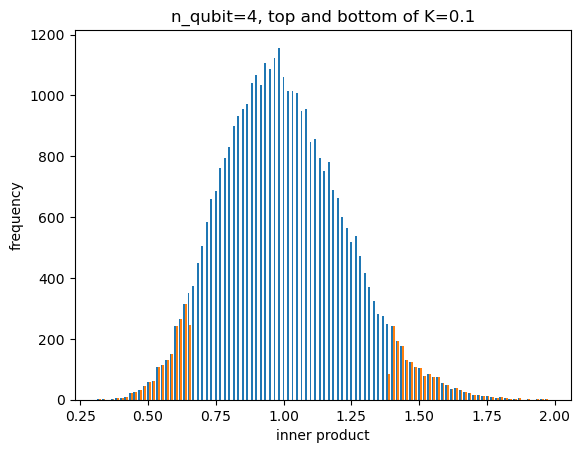

In [10]:
plt.hist(
    [rho_vec @ get_actual_Amat(n_qubit), rho_vec @ Amat],
    bins=100,
    label=["all", "top and bottom"],
)
plt.xlabel("inner product")
plt.ylabel("frequency")
plt.title(f"{n_qubit=}, top and bottom of {K=}")
plt.show()

## approximate calculation of RoM

By using the matrix obtained by the FWHT, we can calculate the RoM approximately,
which is very near to the exact RoM.


In [14]:
print("== approximate solution ===")
print(calculate_RoM_custom(Amat, rho_vec))

== approximate solution ===
(1.3796759521106376, array([0.00128977, 0.        , 0.        , ..., 0.        , 0.        ,
       0.        ]))


In [15]:
from exputils.RoM.actual import calculate_RoM_actual


print("=== exact solution ===")
print(calculate_RoM_actual(n_qubit, rho_vec))

=== exact solution ===
(1.376209751003376, array([0., 0., 0., ..., 0., 0., 0.]))


## To End

Now we can compute the RoM utilizing the inner products!

For more details, please see the each function's implementation and notebooks in the `doc/summary` directory.

We hope you enjoy the RoM calculation!
